## Ejercicio 3

Agregar parada temprana, utilizando un conjunto de validación, distinto del conjunto de entrenamiento y de test (este punto requiere generar más ejemplos). Esto es: verificar el valor de loss o de accuracy cada N epochs (donde N es un parámetro de configuración) utilizando el conjunto de validación, y detener el entrenamiento en caso de que estos valores hayan empeorado (puede incluirse una tolerancia para evitar cortar el entrenamiento por alguna oscilación propia del proceso de entrenamiento).


Se nos pide ahora agregar una cross validation con early stop (para evitar el overfitting). Esto lo podemos lograr como dice la consigna, validando los resultados cada cierta cantidad de epochs y verificando que el algoritmo efectivamente este mejorando, si no lo hace, se corta el entrenamiento.

Vamos a crear una funcion de parada temprana que se ejecute cada N epochs (parametro que establecemos nosotros). Se establece un valor de tolerancia ajustable en la propia funcion, que nos permite establecer un margen de error para que el algoritmo no se corte por una oscilacion propia del entrenamiento.

### Codigo base con ciertas modificaciones

In [61]:
import numpy as np
import matplotlib.pyplot as plt

# Generador basado en ejemplo del curso CS231 de Stanford: 
# CS231n Convolutional Neural Networks for Visual Recognition
# (https://cs231n.github.io/neural-networks-case-study/)
def generar_datos_clasificacion(cantidad_ejemplos, cantidad_clases):
    FACTOR_ANGULO = 0.79
    AMPLITUD_ALEATORIEDAD = 0.1

    # Calculamos la cantidad de puntos por cada clase, asumiendo la misma cantidad para cada 
    # una (clases balanceadas)
    n = int(cantidad_ejemplos / cantidad_clases)

    # Entradas: 2 columnas (x1 y x2)
    x = np.zeros((cantidad_ejemplos, 2))
    
    # Salida deseada ("target"): 1 columna que contendra la clase correspondiente (codificada como un entero)
    t = np.zeros(cantidad_ejemplos, dtype="uint8")  # 1 columna: la clase correspondiente (t -> "target")
    
    randomgen = np.random.default_rng()

    # Por cada clase (que va de 0 a cantidad_clases)...
    for clase in range(cantidad_clases):
        # Tomando la ecuacion parametrica del circulo (x = r * cos(t), y = r * sin(t)), generamos 
        # radios distribuidos uniformemente entre 0 y 1 para la clase actual, y agregamos un poco de
        # aleatoriedad
        radios = np.linspace(0, 1, n) + AMPLITUD_ALEATORIEDAD * randomgen.standard_normal(size=n)

        # ... y angulos distribuidos tambien uniformemente, con un desfasaje por cada clase
        angulos = np.linspace(clase * np.pi * FACTOR_ANGULO, (clase + 1) * np.pi * FACTOR_ANGULO, n)

        # Generamos un rango con los subindices de cada punto de esta clase. Este rango se va
        # desplazando para cada clase: para la primera clase los indices estan en [0, n-1], para
        # la segunda clase estan en [n, (2 * n) - 1], etc.
        indices = range(clase * n, (clase + 1) * n)

        # Generamos las "entradas", los valores de las variables independientes. Las variables:
        # radios, angulos e indices tienen n elementos cada una, por lo que le estamos agregando
        # tambien n elementos a la variable x (que incorpora ambas entradas, x1 y x2)
        x1 = radios * np.sin(angulos)
        x2 = radios * np.cos(angulos)
        x[indices] = np.c_[x1, x2] #Esta función une al vector x1 y a x2. Es como que genera una matriz.

        # Guardamos el valor de la clase que le vamos a asociar a las entradas x1 y x2 que acabamos
        # de generar
        t[indices] = clase

    return x, t


def inicializar_pesos(n_entrada, n_capa_2, n_capa_3):
    randomgen = np.random.default_rng()

    #w son los pesos, b son los sesgos. En este caso tenemos 2 capas luego de la capa de entrada
    
    #Se inicializan con un valor bajo. Por eso se multiplilcan por 0.1
    w1 = 0.1 * randomgen.standard_normal((n_entrada, n_capa_2))
    b1 = 0.1 * randomgen.standard_normal((1, n_capa_2))

    w2 = 0.1 * randomgen.standard_normal((n_capa_2, n_capa_3))
    b2 = 0.1 * randomgen.standard_normal((1,n_capa_3))

    return {"w1": w1, "b1": b1, "w2": w2, "b2": b2}


def ejecutar_adelante(x, pesos):
    # Funcion de entrada (a.k.a. "regla de propagacion") para la primera capa oculta
    z = x.dot(pesos["w1"]) + pesos["b1"]
    #Por más que b1 sea un vector y la multiplicación de x*w sea una matriz, como tienen la misma cantidad de columnas, se puede hacer la suma porque numpy intuye que queremos sumar a cada fila de la matriz el mismo vector b.

    # Funcion de activacion ReLU para la capa oculta (h -> "hidden")
    h = np.maximum(0, z)
    #Esta función de activación convierte a 0 los valores negativos, y deja como está a los valores positivos.

    # Salida de la red (funcion de activacion lineal). Esto incluye la salida de todas
    # las neuronas y para todos los ejemplos proporcionados
    y = h.dot(pesos["w2"]) + pesos["b2"]

    return {"z": z, "h": h, "y": y}

#Esto se usaría una vez que la red neuronal ya está entrenada
def clasificar(x, pesos):
    # Corremos la red "hacia adelante"
    resultados_feed_forward = ejecutar_adelante(x, pesos)
    
    # Buscamos la(s) clase(s) con scores mas altos (en caso de que haya mas de una con 
    # el mismo score estas podrian ser varias). Dado que se puede ejecutar en batch (x 
    # podria contener varios ejemplos), buscamos los maximos a lo largo del axis=1 
    # (es decir, por filas)
    max_scores = np.argmax(resultados_feed_forward["y"], axis=1)

    # Tomamos el primero de los maximos (podria usarse otro criterio, como ser eleccion aleatoria)
    # Nuevamente, dado que max_scores puede contener varios renglones (uno por cada ejemplo),
    # retornamos la primera columna
    return max_scores#[:, 0]






### Creación de función para medir la precisión

Vamos a codear una funcion que tome como parametros un conjunto de distintos ejemplos, con sus respectivos target y los pesos y bias de la red, y nos devuelva la precision de clasificacion de la red.

In [62]:
def calculaPrecision(conjuntoEjemplos,target,pesos):

    #Ejecutamos la funcion clasificar para obtener la claficacion que la red hace de los ejemplos que le pasamos
    resultadosClasificacion = clasificar(conjuntoEjemplos,pesos)
    #La funcion clasificar nos entrega un vector donde cada elemento es el indice de la neurona que la red considera que es correcta (mayor valor)
    #Dado que son 3 salidas, una para cada clase, debemos contrastar el valor entregado con el target, el cual indica la clase correcta

    #Utilizamos funcion equal de numpy, la cual nos entrega un vector con valores booleanos al comparar 2 vectores que le pasemos como parametro, elemento a elemento
    #En este caso, comparamos el vector de resultados de clasificacion con el vector de target
    resultadosCorrectos = np.equal(resultadosClasificacion,target)

    #Calculamos precision
    precision=(len(resultadosCorrectos[resultadosCorrectos==True])/len(resultadosCorrectos))*100
    return precision
     

### Creacion de funcion de Early Stop o Parada Temprana

In [63]:
def earlyStop (xValidacion, tValidacion, pesos, vectorPrecision, ultimoEpoch):

    #Llamamos a la funcion para evaluar la precision con el conjunto de validacion y metemos esta precision al vector de precisiones
    precision = calculaPrecision(xValidacion,tValidacion,pesos)
    vectorPrecision.append(precision)

    #Evaluamos este ultimo valor de precision con el anterior, si es menor, retornamos True, si no, retornamos False
    #Establecemos un valor de tolerancia para que no se detenga el entrenamiento por una diferencia minima (oscilaciones)
    TOLERANCIA = 20 #Esto quiere decir que tienen que haber pasado 20*N epochs para que se detenga el entrenamiento
    if len(vectorPrecision)>TOLERANCIA:
        if vectorPrecision[-1]<vectorPrecision[-2]:
            print("Se detuvo el entrenamiento en el epoch: ",ultimoEpoch)
            return True
        else:
            return False

### Funcion de train

Separamos la funcion de train del resto del codigo base para poder declarar la funcion de earlyStop antes

In [64]:
# x: n entradas para cada uno de los m ejemplos(nxm)
# t: salida correcta (target) para cada uno de los m ejemplos (m x 1)
# pesos: pesos (W y b)
def train(x, t, pesos, learning_rate, epochs, xValidacion, tValidacion, validationEpoch):
    # Cantidad de filas (i.e. cantidad de ejemplos)
    m = np.size(x, 0)

    #Definimos el vector de precision
    vectorPrecision=[] 
    
    for i in range(epochs):
        # Ejecucion de la red hacia adelante
        resultados_feed_forward = ejecutar_adelante(x, pesos)
        y = resultados_feed_forward["y"]
        h = resultados_feed_forward["h"]
        z = resultados_feed_forward["z"]

        # LOSS
        # a. Exponencial de todos los scores
        exp_scores = np.exp(y)

        # b. Suma de todos los exponenciales de los scores, fila por fila (ejemplo por ejemplo).
        #    Mantenemos las dimensiones (indicamos a NumPy que mantenga la segunda dimension del
        #    arreglo, aunque sea una sola columna, para permitir el broadcast correcto en operaciones
        #    subsiguientes)
        sum_exp_scores = np.sum(exp_scores, axis=1, keepdims=True)

        # c. "Probabilidades": normalizacion de las exponenciales del score de cada clase (dividiendo por 
        #    la suma de exponenciales de todos los scores), fila por fila
        p = exp_scores / sum_exp_scores

        # d. Calculo de la funcion de perdida global. Solo se usa la probabilidad de la clase correcta, 
        #    que tomamos del array t ("target")
        loss = (1 / m) * np.sum( -np.log( p[range(m), t] ))

        # Mostramos solo cada 1000 epochs
        if i %1000 == 0:
            print("Loss epoch", i, ":", loss)


        # Extraemos los pesos a variables locales
        w1 = pesos["w1"]
        b1 = pesos["b1"]
        w2 = pesos["w2"]
        b2 = pesos["b2"]

        # Ajustamos los pesos: Backpropagation
        dL_dy = p                # Para todas las salidas, L' = p (la probabilidad)...
        dL_dy[range(m), t] -= 1  # ... excepto para la clase correcta
        dL_dy /= m

        dL_dw2 = h.T.dot(dL_dy)                         # Ajuste para w2
        dL_db2 = np.sum(dL_dy, axis=0, keepdims=True)   # Ajuste para b2

        dL_dh = dL_dy.dot(w2.T)
        
        dL_dz = dL_dh       # El calculo dL/dz = dL/dh * dh/dz. La funcion "h" es la funcion de activacion de la capa oculta,
        dL_dz[z <= 0] = 0   # para la que usamos ReLU. La derivada de la funcion ReLU: 1(z > 0) (0 en otro caso)

        dL_dw1 = x.T.dot(dL_dz)                         # Ajuste para w1
        dL_db1 = np.sum(dL_dz, axis=0, keepdims=True)   # Ajuste para b1

        # Aplicamos el ajuste a los pesos
        w1 += -learning_rate * dL_dw1
        b1 += -learning_rate * dL_db1
        w2 += -learning_rate * dL_dw2
        b2 += -learning_rate * dL_db2

        # Actualizamos la estructura de pesos
        # Extraemos los pesos a variables locales
        pesos["w1"] = w1
        pesos["b1"] = b1
        pesos["w2"] = w2
        pesos["b2"] = b2

        #Evaluamos si nos encontramos en el epoch de validacion
        if i % validationEpoch == 0:
            #Llamamos a la funcion de parada temprana, la cual nos entrega un booleano
            #Le pasamos el conjunto de validacion, target de validacion, pesos, vector de prescion y numero actual de epoch (i)
            flagEarlyStop = earlyStop(xValidacion, tValidacion, pesos, vectorPrecision,i)
        
        #Si el flag de parada temprana es True, paramos el entrenamiento, si no seguimos con el bucle for normalmente
        if flagEarlyStop:
            break
    
    #Entregamos los nuevos pesos
    nuevosPesos = pesos
    return nuevosPesos

### Funcion Iniciar

Movemos la funcion iniciar aqui, de esta manera podemos ejecutar la funcion que acabamos de crear sin problema

In [65]:
def iniciar(numero_clases, numero_ejemplos, graficar_datos):

    # Generamos datos del conjunto train
    x, t = generar_datos_clasificacion(numero_ejemplos, numero_clases)

    #Generamos datos del conjunto test con el mismo numero de ejemplos y clases
    xTest,tTest = generar_datos_clasificacion(numero_ejemplos, numero_clases)

    #Generamos datos del conjunto de validacion con el mismo numero de eje,plos y clases

    xValidacion,tValidacion = generar_datos_clasificacion(numero_ejemplos, numero_clases)

    # Graficamos los datos si es necesario
    if graficar_datos:
        # Parametro: "c": color (un color distinto para cada clase en t)
        plt.scatter(x[:, 0], x[:, 1], c=t)
        plt.show()

    # Inicializa pesos de la red
    NEURONAS_CAPA_OCULTA = 100
    NEURONAS_ENTRADA = 2
    pesos = inicializar_pesos(n_entrada=NEURONAS_ENTRADA, n_capa_2=NEURONAS_CAPA_OCULTA, n_capa_3=numero_clases)

    # Entrenamos a la red. Le pasamos los conjuntos de train y validacion (para parada temprana)
    LEARNING_RATE=1
    EPOCHS=10000
    VALIDATION_EPOCH=100 #Cada cuantas epochs hacemos el cross validation con el conjunto de validacion para la early stop
    nuevosPesos=train(x, t, pesos, LEARNING_RATE, EPOCHS, xValidacion, tValidacion, VALIDATION_EPOCH)

    #Calculamos precision de la red para el conjunto train y para el conjunto test
    precisionTrain=calculaPrecision(x, t, nuevosPesos)
    print("Precision en conjunto de Train: "+str(precisionTrain)+"%")
    precisionTest=calculaPrecision(xTest, tTest, nuevosPesos)
    print("Precision en conjunto de Test: "+str(precisionTest)+"%")

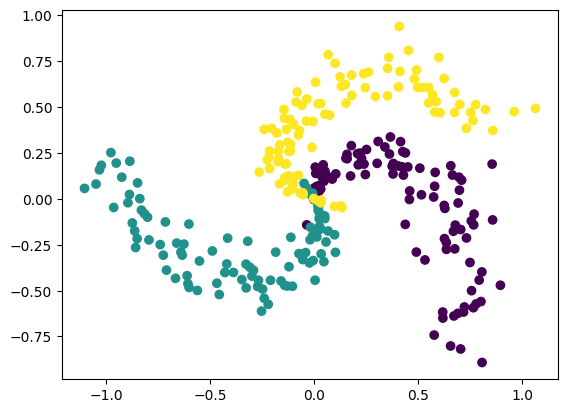

Loss epoch 0 : 1.1045304789847092
Loss epoch 1000 : 0.1628160927659947
Loss epoch 2000 : 0.14628442718608764
Se detuvo el entrenamiento en el epoch:  2000
Precision en conjunto de Train: 95.0%
Precision en conjunto de Test: 96.33333333333334%


In [66]:
iniciar(3,300,True)